In [1]:
import psycopg2
import pandas as pd
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt
import xlrd
import matplotlib.dates as mdate
import matplotlib.ticker as mtick
import datetime
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

In [2]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [3]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [4]:
start_dt = '2021-03-01'
end_dt = '2021-08-02'

1. average slots decline MoM (used to be 11.5, now its lower)

FDR devices - delivery is lower? KB thinks there's an issue here

2. fill rate is dropping 

- Yield says there are the same campaigns - not true

- Not delivering apps

In [11]:
vzw = pd.read_excel('files/Device List.xls', 'Verizon')
att = pd.read_excel('files/Device List.xls', 'AT&T')
crk = pd.read_excel('files/Device List.xls', 'Cricket')
amx = pd.read_excel('files/Device List.xls', 'AMX')
trf = pd.read_excel('files/Device List.xls', 'Tracfone')
usc = pd.read_excel('files/Device List.xls', 'US Cellular')
vzw['ELI'] = 'Verizon'
att['ELI'] = 'ATT'
crk['ELI'] = 'Cricket'
amx['ELI'] = 'AMXAPK'
trf['ELI'] = 'Tracfone'
usc['ELI'] = 'USCellular'
sheet_list = [crk,vzw,att,amx,trf,usc]
for s in sheet_list:
    s.columns = s.columns.str.replace('Sponsored Slots','# of Sponsored Slots')
    s.columns = s.columns.str.replace('# of # of','# of')
    s.columns = s.columns.str.replace('Games Launcher ONLY ON 6.0+','Games Launcher', regex=False)
    s['Total Slots'] = pd.to_numeric(s['Total Slots'], errors='coerce',downcast = 'float')
    s['# of Sponsored Slots'] = pd.to_numeric(s['# of Sponsored Slots'], errors='coerce',downcast = 'float')
    s['# of House Apps'] = pd.to_numeric(s['# of House Apps'], errors='coerce',downcast = 'float')
device_slots = pd.concat(sheet_list, join = 'outer')
device_slots.columns = [x.strip() for x in device_slots.columns]
device_slots.dtypes

ELI                      object
Manufacturer             object
Device Code Name         object
Model #                  object
Device Market Name       object
Silent Site ID            int64
Games Site ID            object
Tablet?                  object
Prepaid/PostPaid         object
Tier                     object
Total Slots             float32
# of Sponsored Slots    float32
# of Tracker Apps        object
Tracker Apps             object
Games Launcher           object
# of House Apps         float32
Unnamed: 16              object
For Automation           object
OS Ceiling              float64
AppList Site ID         float64
House Apps               object
Slot increase           float64
dtype: object

In [12]:
silent_sites = device_slots[['ELI','Silent Site ID', 'Total Slots', '# of Sponsored Slots', '# of House Apps', 'Tier']]
applist_sites = device_slots[['ELI','AppList Site ID','Total Slots','# of Sponsored Slots','# of House Apps', 'Tier']]
games_sites = device_slots[['ELI','Games Site ID','Total Slots','# of Sponsored Slots','# of House Apps', 'Tier']]

silent_sites.columns = ['c_name','site_id','all_config_slots','sponsored_config_slots','house_config_slots', 'Tier']
applist_sites.columns = ['c_name','site_id','all_config_slots','sponsored_config_slots','house_config_slots', 'Tier']
games_sites.columns = ['c_name','site_id','all_config_slots','sponsored_config_slots','house_config_slots', 'Tier']

device_slots_exploded = pd.concat([silent_sites,applist_sites,games_sites],join = 'outer')
device_slots_exploded

c_name  site_id  all_config_slots  sponsored_config_slots  \
0      Cricket     9179               8.0                     4.0   
1      Cricket     9184              18.0                    14.0   
2      Cricket     9285              19.0                    14.0   
3      Cricket     9356               8.0                     3.0   
4      Cricket     9373              19.0                    14.0   
..         ...      ...               ...                     ...   
95  USCellular  12586.0               NaN                    12.0   
96  USCellular  12588.0               NaN                    12.0   
97  USCellular  12590.0               NaN                    12.0   
98  USCellular  12592.0               NaN                    12.0   
99  USCellular  12594.0               NaN                    12.0   

    house_config_slots    Tier  
0                  4.0  tier 3  
1                  4.0  tier 3  
2                  4.0  tier 3  
3                  4.0  tier 3  
4                  4.0  tier 3  
..                 ...     ...  
95                 NaN     NaN  
96                 NaN     NaN  
97                 NaN     NaN  
98                 NaN     NaN  
99                 NaN     NaN  

[2082 rows x 6 columns]

In [13]:
query_preload = """
select
    t1.date
    , t1.siteid
    , t1.site_name
    , t1.isfdr
    , t1.c_name
    , t1.kind
    , t1.manufacturer
    , t1.model
    , sum(t1.device_count) as device_count
    , sum(t2.all_preloads) as all_preloads
    , sum(t2.house_preloads) as house_preloads
    , sum(t2.sponsored_preloads) as sponsored_preloads
    , sum(t2.house_campaign_ct) as house_campaign_ct
    , sum(t2.sponsored_campaign_ct) as sponsored_campaign_ct
from
(
    select
        f.c_name
        , f.isfdr
        , date(f.createdate at time zone 'utc' at time zone 'est') as date 
        , f.siteid
        , max(f.kind) kind
        , max(f.manufacturer) manufacturer
        , max(f.model) model
        , max(f.site_name) as site_name
        , count(distinct imei) as device_count
    from rawdata.dt_device_report f
    join rawdata.site s
        on f.siteid = s.site_id
    where
        date(f.createdate at time zone 'utc' at time zone 'est') >= date('{start_dt}')
        and date(f.createdate at time zone 'utc' at time zone 'est') <= date('{end_dt}')
        and kind = 'production'
        and f.rs_carrier_id in (1,2,11,13,28,44)
        and s.site_name not like '%RDNS%'
        and f.processtypeid = 1
    group by 1,2,3,4
) t1 
left join
(
    select
        date(ctp.tracking_time) as date
        , case 
            when p.partner_name like '%America Movil%' then 'AMXAPK'
            else replace(replace(substring(p.partner_name,3),' ',''),'&','')
        end as c_name
        , ctp.site_id
        , case when ctp.placement_id = 99 then 1 else 0 end as isfdr
        , count(distinct referrer) as all_preloads
        , count(distinct case when settled_price_per_download = 0 then referrer else NULL end) as house_preloads
        , count(distinct case when settled_price_per_download > 0 then referrer else NULL end) as sponsored_preloads
        , count(distinct case when settled_price_per_download = 0 then ctp.campaign_id else NULL end) as house_campaign_ct
        , count(distinct case when settled_price_per_download > 0 then ctp.campaign_id else NULL end) as sponsored_campaign_ct
    from rawdata.campaign_tracking_active_preload ctp
    join rawdata.site s
        on ctp.site_id = s.site_id
    join rawdata.partner_information p
        on s.partner_id = p.partner_id 
    where
        date(ctp.tracking_time) >= date('{start_dt}')
        and date(ctp.tracking_time) <= date('{end_dt}')
    group by 1,2,3,4
) t2 
    on t1.siteid = t2.site_id 
    and t1.date = t2.date 
    and t1.isfdr = t2.isfdr
    and t1.c_name = t2.c_name
group by 1,2,3,4,5,6,7,8
;
"""

In [14]:
cur_atlas.execute(query_preload.format(start_dt = start_dt, end_dt = end_dt))
df_preload = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [15]:
df_preload.rename(columns = {'siteid':'site_id'}, inplace = True)

In [16]:
df = pd.merge(df_preload, device_slots_exploded, on = ['site_id','c_name'])

In [18]:
df['date'] = pd.to_datetime(df.date)
df['month'] = df['date'].dt.month

In [19]:
carriers = df.c_name.unique().tolist()

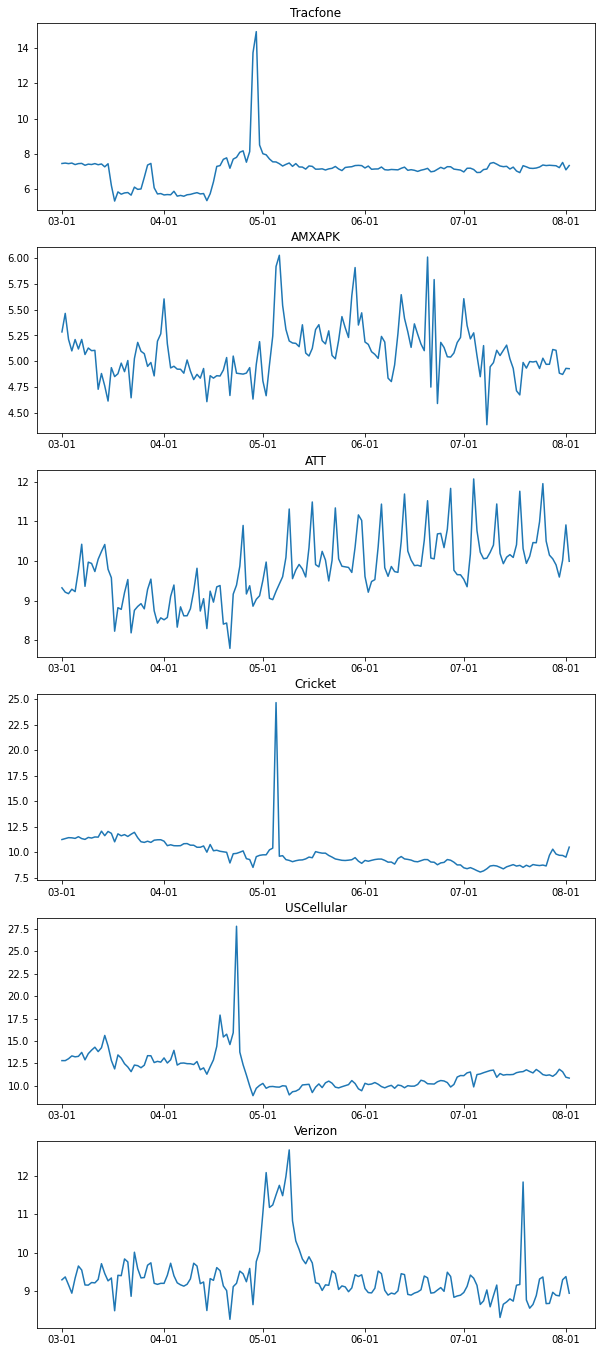

In [20]:
bydate = df.pivot_table(values = ['device_count','all_preloads','sponsored_preloads'], index = 'date', columns = 'c_name', aggfunc = np.sum)

fig, ax = plt.subplots(len(carriers),1, figsize = (10, 4*len(carriers)))
for n in range(len(carriers)):
    carrier = carriers[n]
    bydate[('sponsored_slots', carrier)] = bydate[('sponsored_preloads', carrier)]/bydate[('device_count', carrier)]
    ax[n].plot(bydate[[('sponsored_slots', carrier)]])
    ax[n].xaxis.set_major_formatter(mdate.DateFormatter('%m-%d'))
    ax[n].set_title(carrier)
#     ax[n].set_ylim(0,bydate[('sponsored_slots', carrier)].max())



In [21]:
i = 'c_name'
pivot = df.pivot_table(values = ['device_count','sponsored_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads','All'), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]
    pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]

sov_pivot[('slot_decrease')] = sov_pivot[('sponsored_slots',3)]-sov_pivot[('sponsored_slots',7)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('slot_decrease',''):'{:,.1f}'
             }
sov_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ('slot_decrease'))


# Cricket

In [22]:
cricket = df.loc[df.c_name == 'Cricket']
att = df.loc[df.c_name == 'ATT']

In [23]:
att_bydate = att.groupby('date')['device_count','all_preloads','sponsored_preloads','house_preloads'].sum()
att_bydate['all_slots'] = att_bydate.all_preloads/att_bydate.device_count
att_bydate['sponsored_slots'] = att_bydate.sponsored_preloads/att_bydate.device_count
att_bydate['house_slots'] = att_bydate.house_preloads/att_bydate.device_count

<ipython-input-23-54ce5bd5a404>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  att_bydate = att.groupby('date')['device_count','all_preloads','sponsored_preloads','house_preloads'].sum()


<ipython-input-24-ead397467e76>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cricket_bydate = cricket.groupby('date')['device_count','all_preloads','sponsored_preloads','house_preloads'].sum()


Text(0.5, 1.0, 'all slots - att')

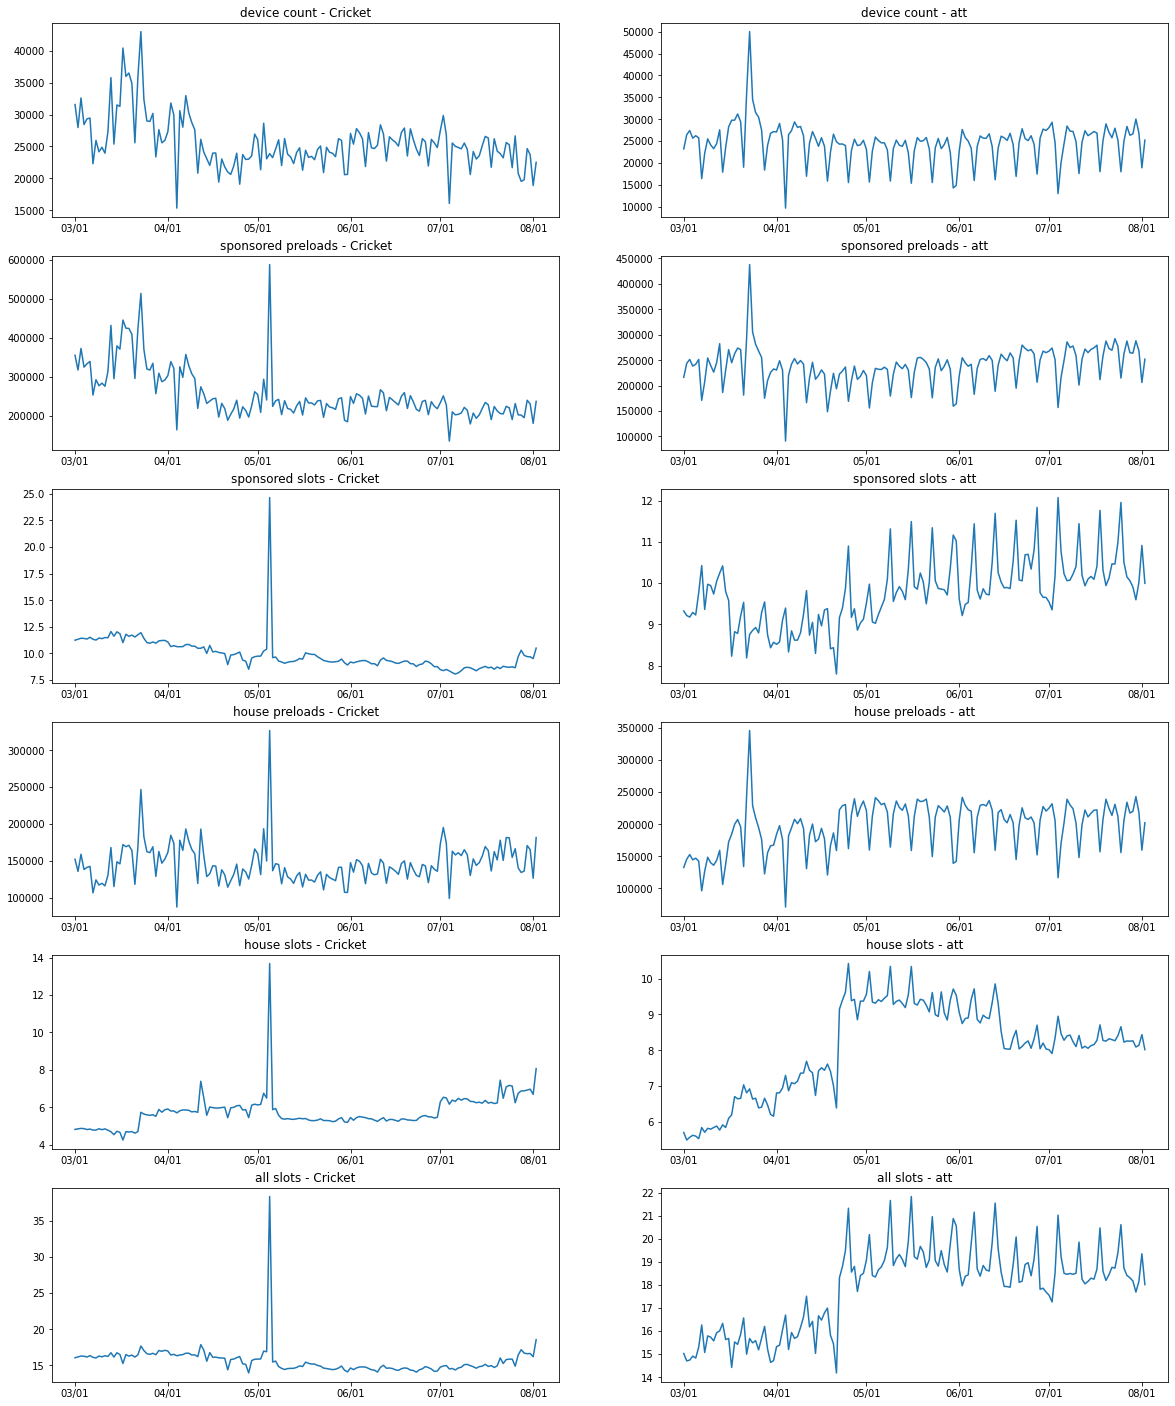

In [24]:
cricket_bydate = cricket.groupby('date')['device_count','all_preloads','sponsored_preloads','house_preloads'].sum()
cricket_bydate['all_slots'] = cricket_bydate.all_preloads/cricket_bydate.device_count
cricket_bydate['sponsored_slots'] = cricket_bydate.sponsored_preloads/cricket_bydate.device_count
cricket_bydate['house_slots'] = cricket_bydate.house_preloads/cricket_bydate.device_count

fig, ax = plt.subplots(6,2, figsize = (20,25))
ax[0,0].plot(cricket_bydate[['device_count']])
ax[0,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0,0].set_title('device count - Cricket')
ax[1,0].plot(cricket_bydate[['sponsored_preloads']])
ax[1,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,0].set_title('sponsored preloads - Cricket')
ax[2,0].plot(cricket_bydate[['sponsored_slots']])
ax[2,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,0].set_title('sponsored slots - Cricket')
ax[3,0].plot(cricket_bydate[['house_preloads']])
ax[3,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[3,0].set_title('house preloads - Cricket')
ax[4,0].plot(cricket_bydate[['house_slots']])
ax[4,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[4,0].set_title('house slots - Cricket')
ax[5,0].plot(cricket_bydate[['all_slots']])
ax[5,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[5,0].set_title('all slots - Cricket')

# att 
ax[0,1].plot(att_bydate[['device_count']])
ax[0,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0,1].set_title('device count - att')
ax[1,1].plot(att_bydate[['sponsored_preloads']])
ax[1,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,1].set_title('sponsored preloads - att')
ax[2,1].plot(att_bydate[['sponsored_slots']])
ax[2,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,1].set_title('sponsored slots - att')
ax[3,1].plot(att_bydate[['house_preloads']])
ax[3,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[3,1].set_title('house preloads - att')
ax[4,1].plot(att_bydate[['house_slots']])
ax[4,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[4,1].set_title('house slots - att')
ax[5,1].plot(att_bydate[['all_slots']])
ax[5,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[5,1].set_title('all slots - att')

Text(0.5, 1.0, 'all slots - Cricket')

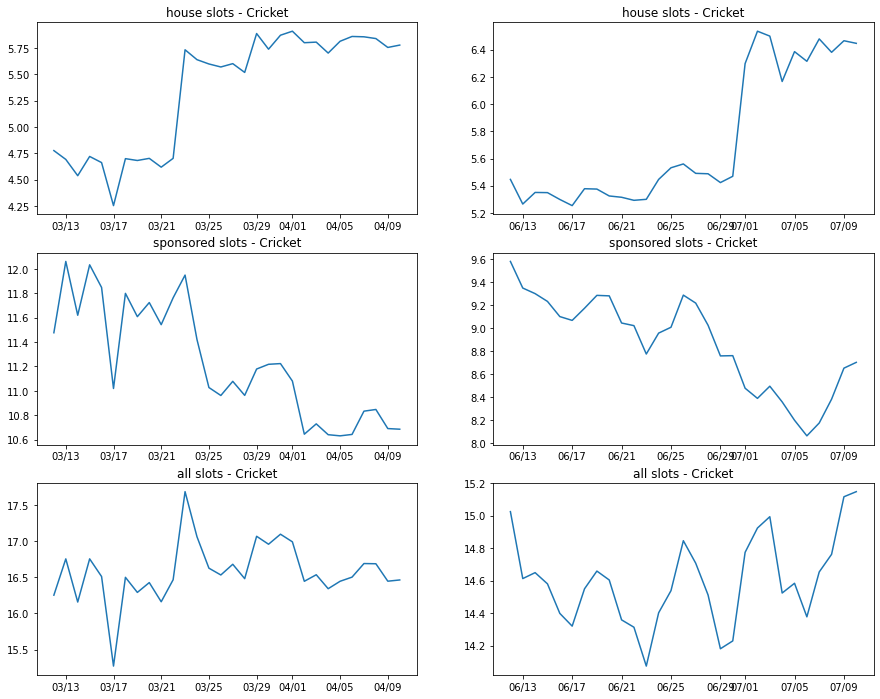

In [25]:
fig, ax = plt.subplots(3,2,figsize = (15,12))
ax[0,0].plot(cricket_bydate.loc[(cricket_bydate.index >= '2021-03-12') & (cricket_bydate.index <= '2021-04-10'), ['house_slots']])
ax[0,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0,0].set_title('house slots - Cricket')
ax[1,0].plot(cricket_bydate.loc[(cricket_bydate.index >= '2021-03-12') & (cricket_bydate.index <= '2021-04-10'), ['sponsored_slots']])
ax[1,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,0].set_title('sponsored slots - Cricket')
ax[2,0].plot(cricket_bydate.loc[(cricket_bydate.index >= '2021-03-12') & (cricket_bydate.index <= '2021-04-10'), ['all_slots']])
ax[2,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,0].set_title('all slots - Cricket')
ax[0,1].plot(cricket_bydate.loc[(cricket_bydate.index >= '2021-06-12') & (cricket_bydate.index <= '2021-07-10'), ['house_slots']])
ax[0,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0,1].set_title('house slots - Cricket')
ax[1,1].plot(cricket_bydate.loc[(cricket_bydate.index >= '2021-06-12') & (cricket_bydate.index <= '2021-07-10'), ['sponsored_slots']])
ax[1,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,1].set_title('sponsored slots - Cricket')
ax[2,1].plot(cricket_bydate.loc[(cricket_bydate.index >= '2021-06-12') & (cricket_bydate.index <= '2021-07-10'), ['all_slots']])
ax[2,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,1].set_title('all slots - Cricket')

In [26]:
cricket_bydate.reset_index(inplace = True)
cricket_bydate['month'] = cricket_bydate.date.dt.month
cricket_bymonth = cricket_bydate.groupby('month').sum()

cricket_bymonth['all_slots'] = cricket_bymonth.all_preloads/cricket_bymonth.device_count
cricket_bymonth['sponsored_slots'] = cricket_bymonth.sponsored_preloads/cricket_bymonth.device_count
cricket_bymonth['house_slots'] = cricket_bymonth.house_preloads/cricket_bymonth.device_count
cricket_bymonth

device_count  all_preloads  sponsored_preloads  house_preloads  \
month                                                                   
3            927208    15266211.0          10630541.0       4635670.0   
4            737611    11928058.0           7542985.0       4385073.0   
5            738857    11666452.0           7386156.0       4280296.0   
6            769537    11182267.0           7034138.0       4148129.0   
7            746638    11397316.0           6521614.0       4875702.0   
8             41390      723943.0            416036.0        307907.0   

       all_slots  sponsored_slots  house_slots  
month                                           
3      16.464710        11.465109     4.999601  
4      16.171204        10.226237     5.944967  
5      15.789865         9.996733     5.793132  
6      14.531162         9.140740     5.390422  
7      15.264849         8.734640     6.530209  
8      17.490771        10.051607     7.439164

In [27]:
i = 'isfdr'
pivot = cricket.pivot_table(values = ['device_count','sponsored_preloads','house_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]
    sov_pivot[('house_slots',i)] = pivot[('house_preloads',i)]/pivot[('device_count',i)]

sov_pivot[('sp_slot_change')] = sov_pivot[('sponsored_slots',7)]-sov_pivot[('sponsored_slots',3)]
sov_pivot[('ho_slot_change')] = sov_pivot[('house_slots',7)]-sov_pivot[('house_slots',3)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('house_preloads',3):'{:,.1f}%'
              ,('house_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('house_preloads',4):'{:,.1f}%'
              ,('house_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('house_preloads',5):'{:,.1f}%'
              ,('house_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('house_preloads',6):'{:,.1f}%'
              ,('house_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('house_preloads',7):'{:,.1f}%'
              ,('house_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('sp_slot_change',''):'{:,.1f}'
              ,('ho_slot_change',''):'{:,.1f}'
             }
cols = [('device_count','All'),('sponsored_slots',3),('sponsored_slots',4),('sponsored_slots',5),('sponsored_slots',6),('sponsored_slots',7)
        ,('house_slots',3),('house_slots',4),('house_slots',5),('house_slots',6),('house_slots',7),('sp_slot_change',''),('ho_slot_change','')]
sov_pivot[cols].sort_values(('device_count','All'), ascending = False).head(30).style.format(format_map).background_gradient(cmap=cm, subset = [('sp_slot_change',''),('ho_slot_change','')]).applymap(lambda x:'color: white;background-color:white' if np.isnan(x) else '')


In [28]:
i = 'manufacturer'
pivot = cricket.pivot_table(values = ['device_count','sponsored_preloads','house_preloads','all_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]
    sov_pivot[('house_slots',i)] = pivot[('house_preloads',i)]/pivot[('device_count',i)]
    sov_pivot[('all_slots',i)] = (pivot[('house_preloads',i)]+pivot[('sponsored_preloads',i)])/pivot[('device_count',i)]

sov_pivot[('sp_slot_decrease')] = sov_pivot[('sponsored_slots',3)]-sov_pivot[('sponsored_slots',7)]
sov_pivot[('ho_slot_increase')] = sov_pivot[('house_slots',7)]-sov_pivot[('house_slots',3)]
sov_pivot[('all_slot_change')] = sov_pivot[('all_slots',7)]-sov_pivot[('all_slots',3)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('house_preloads',3):'{:,.1f}%'
              ,('house_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('house_preloads',4):'{:,.1f}%'
              ,('house_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('house_preloads',5):'{:,.1f}%'
              ,('house_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('house_preloads',6):'{:,.1f}%'
              ,('house_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('house_preloads',7):'{:,.1f}%'
              ,('house_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('sp_slot_decrease',''):'{:,.1f}'
              ,('ho_slot_increase',''):'{:,.1f}'
              ,('all_slot_change',''):'{:,.1f}'
             }
cols = [('device_count','All'),('sponsored_slots',3),('sponsored_slots',4),('sponsored_slots',5),('sponsored_slots',6),('sponsored_slots',7)
        ,('house_slots',3),('house_slots',4),('house_slots',5),('house_slots',6),('house_slots',7),('sp_slot_decrease',''),('ho_slot_increase',''),('all_slot_change','')]
sov_pivot.sort_values(('device_count','All'), ascending = False, inplace = True)
sov_pivot[cols].head(30).style.format(format_map).background_gradient(cmap='Reds', subset = [('sp_slot_decrease','')]).background_gradient(cmap='Greens', subset = [('ho_slot_increase',''),('all_slot_change','')]).applymap(lambda x:'color: white;background-color:white' if np.isnan(x) else '')


In [29]:
i = 'site_name'
filters = (cricket.manufacturer.isin(['motorola','TINNO','LGE','Alcatel','ZTE']))
pivot = cricket[filters].pivot_table(values = ['device_count','sponsored_preloads','house_preloads','all_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]
    sov_pivot[('house_slots',i)] = pivot[('house_preloads',i)]/pivot[('device_count',i)]
    sov_pivot[('all_slots',i)] = (pivot[('house_preloads',i)]+pivot[('sponsored_preloads',i)])/pivot[('device_count',i)]

sov_pivot[('sp_slot_decrease')] = sov_pivot[('sponsored_slots',3)]-sov_pivot[('sponsored_slots',7)]
sov_pivot[('ho_slot_increase')] = sov_pivot[('house_slots',7)]-sov_pivot[('house_slots',3)]
sov_pivot[('all_slot_change')] = sov_pivot[('all_slots',7)]-sov_pivot[('all_slots',3)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('house_preloads',3):'{:,.1f}%'
              ,('house_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('house_preloads',4):'{:,.1f}%'
              ,('house_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('house_preloads',5):'{:,.1f}%'
              ,('house_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('house_preloads',6):'{:,.1f}%'
              ,('house_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('house_preloads',7):'{:,.1f}%'
              ,('house_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('sp_slot_decrease',''):'{:,.1f}'
              ,('ho_slot_increase',''):'{:,.1f}'
              ,('all_slot_change',''):'{:,.1f}'
             }
cols = [('device_count','All'),('sponsored_slots',3),('sponsored_slots',4),('sponsored_slots',5),('sponsored_slots',6),('sponsored_slots',7)
        ,('house_slots',3),('house_slots',4),('house_slots',5),('house_slots',6),('house_slots',7),('sp_slot_decrease',''),('ho_slot_increase',''),('all_slot_change','')]
sov_pivot.sort_values(('device_count','All'), ascending = False, inplace = True)
sov_pivot[cols].head(30).style.format(format_map).background_gradient(cmap='Reds', subset = [('sp_slot_decrease','')]).background_gradient(cmap='Greens', subset = [('ho_slot_increase',''),('all_slot_change','')]).applymap(lambda x:'color: white;background-color:white' if np.isnan(x) else '')


In [30]:
top_sites = sov_pivot.iloc[:30].index

filters = (cricket.site_name.isin(top_sites))
top_sites_bymonth = cricket[filters].pivot_table(values = ['device_count','house_preloads','sponsored_preloads'], index = 'month', aggfunc = np.sum)
top_sites_bymonth['house_slots'] = top_sites_bymonth.house_preloads/top_sites_bymonth.device_count
top_sites_bymonth['sponsored_slots'] = top_sites_bymonth.sponsored_preloads/top_sites_bymonth.device_count
top_sites_bymonth

device_count  house_preloads  sponsored_preloads  house_slots  \
month                                                                  
3            576858       3007347.0           6838906.0     5.213323   
4            441588       2706696.0           4630922.0     6.129460   
5            419158       2479294.0           4347646.0     5.914939   
6            419778       2243399.0           3848148.0     5.344251   
7            375434       2395860.0           3292658.0     6.381574   
8             17725        142977.0            178814.0     8.066403   

       sponsored_slots  
month                   
3            11.855441  
4            10.486974  
5            10.372332  
6             9.167103  
7             8.770271  
8            10.088237

In [31]:
i = ['c_name','site_name']
pivot = df.pivot_table(values = ['device_count','sponsored_preloads','house_preloads','all_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
pivot['rank'] = pivot[('device_count','All')].groupby('c_name').rank(ascending = False, method = 'first')
pivot = pivot[pivot['rank'] <= 20]
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot['rank'] = sov_pivot[('device_count','All')].groupby('c_name').rank(ascending = False, method = 'first')
sov_pivot = sov_pivot[sov_pivot['rank'] <= 20]
pivot2 = pivot[pivot.index.get_level_values(0) != 'All'].groupby('c_name').sum()
sov_pivot2 = sov_pivot[sov_pivot.index.get_level_values(0) != 'All'].groupby('c_name').sum()

for i in range(3,8):
    sov_pivot2[('sponsored_slots',i)] = pivot2[('sponsored_preloads',i)]/pivot2[('device_count',i)]
    sov_pivot2[('house_slots',i)] = pivot2[('house_preloads',i)]/pivot2[('device_count',i)]
    sov_pivot2[('all_slots',i)] = (pivot2[('house_preloads',i)]+pivot2[('sponsored_preloads',i)])/pivot2[('device_count',i)]

sov_pivot2[('sp_slot_decrease')] = sov_pivot2[('sponsored_slots',3)]-sov_pivot2[('sponsored_slots',7)]
sov_pivot2[('ho_slot_increase')] = sov_pivot2[('house_slots',7)]-sov_pivot2[('house_slots',3)]
sov_pivot2[('all_slot_change')] = sov_pivot2[('all_slots',7)]-sov_pivot2[('all_slots',3)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('house_preloads',3):'{:,.1f}%'
              ,('house_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('house_preloads',4):'{:,.1f}%'
              ,('house_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('house_preloads',5):'{:,.1f}%'
              ,('house_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('house_preloads',6):'{:,.1f}%'
              ,('house_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('house_preloads',7):'{:,.1f}%'
              ,('house_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('sp_slot_decrease',''):'{:,.1f}'
              ,('ho_slot_increase',''):'{:,.1f}'
              ,('all_slot_change',''):'{:,.1f}'
             }
cols = [('device_count','All'),('sponsored_slots',3),('sponsored_slots',4),('sponsored_slots',5),('sponsored_slots',6),('sponsored_slots',7)
        ,('house_slots',3),('house_slots',4),('house_slots',5),('house_slots',6),('house_slots',7),('sp_slot_decrease',''),('ho_slot_increase',''),('all_slot_change','')]
sov_pivot2.sort_values(('device_count','All'), ascending = False, inplace = True)
sov_pivot2[cols].head(30).style.format(format_map).background_gradient(cmap='Reds', subset = [('sp_slot_decrease','')]).background_gradient(cmap='Greens', subset = [('ho_slot_increase',''),('all_slot_change','')]).applymap(lambda x:'color: white;background-color:white' if np.isnan(x) else '')


Summing top 20 sites, sponsored slots have dropped but house slots offset the drop 50%. added new house app?
Ask Carly about house slot increase (Cricket & AT&T)

ASR - ignite ASR event, or getAds call (lakehouse), column recovery counts. 

Bid floors - look at campaign counts, fill rates, delivery post bid floor 

In [32]:
i = ['site_name']
filters = (cricket.manufacturer.isin(['motorola','TINNO','LGE','Alcatel','ZTE']))
pivot = cricket[filters].pivot_table(values = ['device_count','sponsored_preloads','house_preloads','all_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]
    sov_pivot[('house_slots',i)] = pivot[('house_preloads',i)]/pivot[('device_count',i)]
    sov_pivot[('all_slots',i)] = (pivot[('house_preloads',i)]+pivot[('sponsored_preloads',i)])/pivot[('device_count',i)]

sov_pivot[('sp_slot_decrease')] = sov_pivot[('sponsored_slots',3)]-sov_pivot[('sponsored_slots',7)]
sov_pivot[('ho_slot_increase')] = sov_pivot[('house_slots',7)]-sov_pivot[('house_slots',3)]
sov_pivot[('all_slot_change')] = sov_pivot[('all_slots',7)]-sov_pivot[('all_slots',3)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('house_preloads',3):'{:,.1f}%'
              ,('house_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('house_preloads',4):'{:,.1f}%'
              ,('house_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('house_preloads',5):'{:,.1f}%'
              ,('house_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('house_preloads',6):'{:,.1f}%'
              ,('house_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('house_preloads',7):'{:,.1f}%'
              ,('house_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('sp_slot_decrease',''):'{:,.1f}'
              ,('ho_slot_increase',''):'{:,.1f}'
              ,('all_slot_change',''):'{:,.1f}'
             }
cols = [('device_count','All'),('sponsored_slots',3),('sponsored_slots',4),('sponsored_slots',5),('sponsored_slots',6),('sponsored_slots',7)
        ,('house_slots',3),('house_slots',4),('house_slots',5),('house_slots',6),('house_slots',7),('sp_slot_decrease',''),('ho_slot_increase',''),('all_slot_change','')]
sov_pivot.sort_values(('device_count','All'), ascending = False, inplace = True)
sov_pivot[cols].head(30).style.format(format_map).background_gradient(cmap='Reds', subset = [('sp_slot_decrease','')]).background_gradient(cmap='Greens', subset = [('ho_slot_increase',''),('all_slot_change','')]).applymap(lambda x:'color: white;background-color:white' if np.isnan(x) else '')


In [33]:
cricket_topsites_bydate = cricket[cricket.site_name.isin(top_sites.tolist())].groupby(['date'])['device_count','all_preloads','house_preloads','sponsored_preloads'].sum()
cricket_topsites_bydate['all_slots'] = cricket_topsites_bydate.all_preloads/cricket_topsites_bydate.device_count
cricket_topsites_bydate['sponsored_slots'] = cricket_topsites_bydate.sponsored_preloads/cricket_topsites_bydate.device_count
cricket_topsites_bydate['house_slots'] = cricket_topsites_bydate.house_preloads/cricket_topsites_bydate.device_count


<ipython-input-33-062ded7a25ad>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cricket_topsites_bydate = cricket[cricket.site_name.isin(top_sites.tolist())].groupby(['date'])['device_count','all_preloads','house_preloads','sponsored_preloads'].sum()


Text(0.5, 1.0, 'all slots - Cricket')

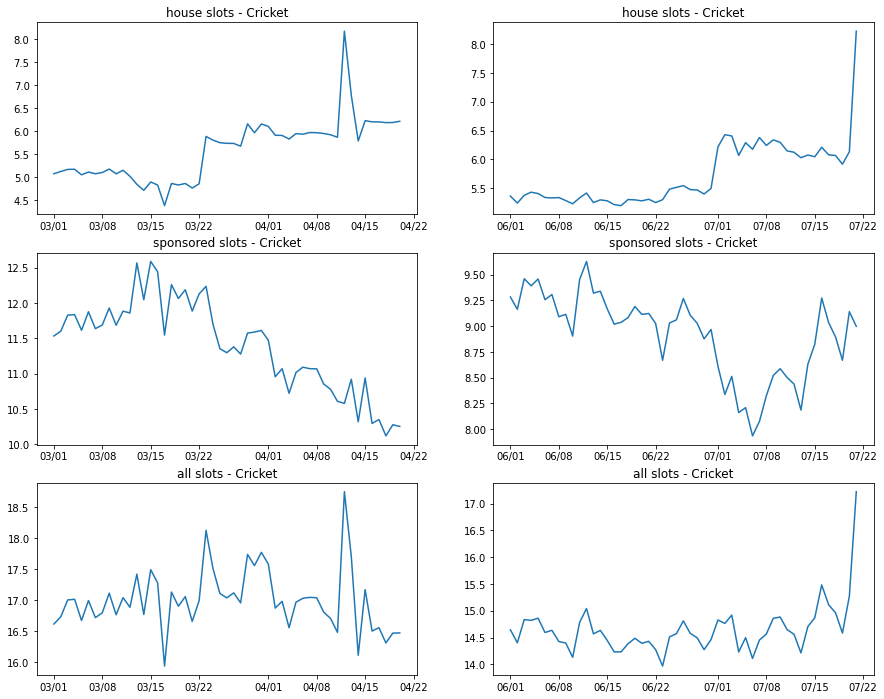

In [34]:
date_start_1 = '2021-03-01'
date_end_1 = '2021-04-20'
date_start_2 = '2021-06-01'
date_end_2 = '2021-07-21'
fig, ax = plt.subplots(3,2,figsize = (15,12))
ax[0,0].plot(cricket_topsites_bydate.loc[(cricket_topsites_bydate.index >= date_start_1) & (cricket_topsites_bydate.index <= date_end_1), ['house_slots']])
ax[0,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0,0].set_title('house slots - Cricket')
ax[1,0].plot(cricket_topsites_bydate.loc[(cricket_topsites_bydate.index >= date_start_1) & (cricket_topsites_bydate.index <= date_end_1), ['sponsored_slots']])
ax[1,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,0].set_title('sponsored slots - Cricket')
ax[2,0].plot(cricket_topsites_bydate.loc[(cricket_topsites_bydate.index >= date_start_1) & (cricket_topsites_bydate.index <= date_end_1), ['all_slots']])
ax[2,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,0].set_title('all slots - Cricket')
ax[0,1].plot(cricket_topsites_bydate.loc[(cricket_topsites_bydate.index >= date_start_2) & (cricket_topsites_bydate.index <= date_end_2), ['house_slots']])
ax[0,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0,1].set_title('house slots - Cricket')
ax[1,1].plot(cricket_topsites_bydate.loc[(cricket_topsites_bydate.index >= date_start_2) & (cricket_topsites_bydate.index <= date_end_2), ['sponsored_slots']])
ax[1,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,1].set_title('sponsored slots - Cricket')
ax[2,1].plot(cricket_topsites_bydate.loc[(cricket_topsites_bydate.index >= date_start_2) & (cricket_topsites_bydate.index <= date_end_2), ['all_slots']])
ax[2,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,1].set_title('all slots - Cricket')

<ipython-input-35-0f0a9f73a798>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cricket_top_sites_bydate = cricket[cricket.site_name.isin(['DT - Cricket - US - Ignite - LG - Escape Plus - LM-X320CM - Silent'])].groupby(['date'])['device_count','all_preloads','house_preloads','sponsored_preloads'].sum()


Text(0.5, 1.0, 'all slots - DT - Cricket - US - Ignite - ZTE - Blade X Max - Z983 - Silent')

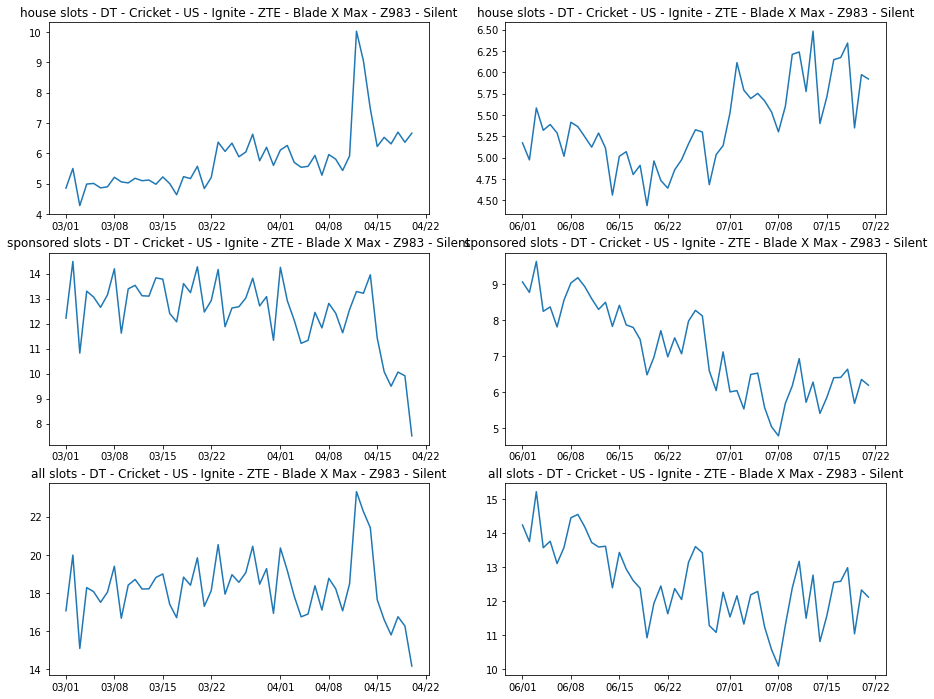

In [35]:
i = 27
cricket_top_sites_bydate = cricket[cricket.site_name.isin(['DT - Cricket - US - Ignite - LG - Escape Plus - LM-X320CM - Silent'])].groupby(['date'])['device_count','all_preloads','house_preloads','sponsored_preloads'].sum()
cricket_top_sites_bydate['all_slots'] = cricket_top_sites_bydate.all_preloads/cricket_top_sites_bydate.device_count
cricket_top_sites_bydate['sponsored_slots'] = cricket_top_sites_bydate.sponsored_preloads/cricket_top_sites_bydate.device_count
cricket_top_sites_bydate['house_slots'] = cricket_top_sites_bydate.house_preloads/cricket_top_sites_bydate.device_count

fig, ax = plt.subplots(3,2,figsize = (15,12))
ax[0,0].plot(cricket_top_sites_bydate.loc[(cricket_top_sites_bydate.index >= date_start_1) & (cricket_top_sites_bydate.index <= date_end_1), ['house_slots']])
ax[0,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0,0].set_title(f'house slots - {top_sites.tolist()[i]}')
ax[1,0].plot(cricket_top_sites_bydate.loc[(cricket_top_sites_bydate.index >= date_start_1) & (cricket_top_sites_bydate.index <= date_end_1), ['sponsored_slots']])
ax[1,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,0].set_title(f'sponsored slots - {top_sites.tolist()[i]}')
ax[2,0].plot(cricket_top_sites_bydate.loc[(cricket_top_sites_bydate.index >= date_start_1) & (cricket_top_sites_bydate.index <= date_end_1), ['all_slots']])
ax[2,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,0].set_title(f'all slots - {top_sites.tolist()[i]}')
ax[0,1].plot(cricket_top_sites_bydate.loc[(cricket_top_sites_bydate.index >= date_start_2) & (cricket_top_sites_bydate.index <= date_end_2), ['house_slots']])
ax[0,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0,1].set_title(f'house slots - {top_sites.tolist()[i]}')
ax[1,1].plot(cricket_top_sites_bydate.loc[(cricket_top_sites_bydate.index >= date_start_2) & (cricket_top_sites_bydate.index <= date_end_2), ['sponsored_slots']])
ax[1,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,1].set_title(f'sponsored slots - {top_sites.tolist()[i]}')
ax[2,1].plot(cricket_top_sites_bydate.loc[(cricket_top_sites_bydate.index >= date_start_2) & (cricket_top_sites_bydate.index <= date_end_2), ['all_slots']])
ax[2,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,1].set_title(f'all slots - {top_sites.tolist()[i]}')

In [36]:
i = ['manufacturer','model']
filters = (cricket.manufacturer.isin(['motorola','TINNO','LGE','Alcatel','ZTE']))
pivot = cricket.pivot_table(values = ['device_count','sponsored_preloads','house_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]
    sov_pivot[('house_slots',i)] = pivot[('house_preloads',i)]/pivot[('device_count',i)]

sov_pivot[('sp_slot_change')] = sov_pivot[('sponsored_slots',7)]-sov_pivot[('sponsored_slots',3)]
sov_pivot[('ho_slot_change')] = sov_pivot[('house_slots',7)]-sov_pivot[('house_slots',3)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('house_preloads',3):'{:,.1f}%'
              ,('house_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('house_preloads',4):'{:,.1f}%'
              ,('house_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('house_preloads',5):'{:,.1f}%'
              ,('house_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('house_preloads',6):'{:,.1f}%'
              ,('house_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('house_preloads',7):'{:,.1f}%'
              ,('house_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('sp_slot_change',''):'{:,.1f}'
              ,('ho_slot_change',''):'{:,.1f}'
             }
cols = [('device_count','All'),('sponsored_slots',3),('sponsored_slots',4),('sponsored_slots',5),('sponsored_slots',6),('sponsored_slots',7)
        ,('house_slots',3),('house_slots',4),('house_slots',5),('house_slots',6),('house_slots',7),('sp_slot_change',''),('ho_slot_change','')]
sov_pivot[cols].sort_values(('device_count','All'), ascending = False).head(30).style.format(format_map).background_gradient(cmap=cm, subset = [('sp_slot_change',''),('ho_slot_change','')]).applymap(lambda x:'color: white;background-color:white' if np.isnan(x) else '')


# US Cellular

In [37]:
uscellular = df.loc[df.c_name == 'USCellular']

<ipython-input-38-8c899283396e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  uscellular_bydate = uscellular.groupby('date')['device_count','all_preloads','sponsored_preloads'].sum()


(0.0, 17.0)

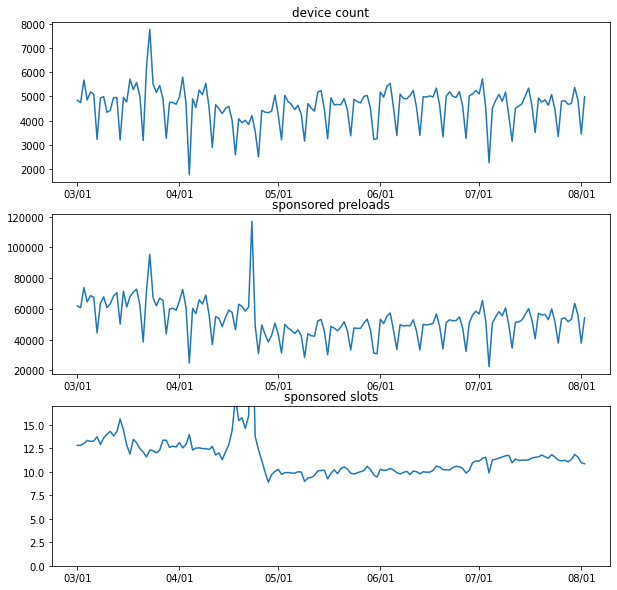

In [38]:
uscellular_bydate = uscellular.groupby('date')['device_count','all_preloads','sponsored_preloads'].sum()
uscellular_bydate['all_slots'] = uscellular_bydate.all_preloads/uscellular_bydate.device_count
uscellular_bydate['sponsored_slots'] = uscellular_bydate.sponsored_preloads/uscellular_bydate.device_count

fig, ax = plt.subplots(3,1, figsize = (10,10))
ax[0].plot(uscellular_bydate[['device_count']])
ax[0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0].set_title('device count')
ax[1].plot(uscellular_bydate[['sponsored_preloads']])
ax[1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1].set_title('sponsored preloads')
ax[2].plot(uscellular_bydate[['sponsored_slots']])
ax[2].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2].set_title('sponsored slots')
ax[2].set_ylim(0,17)

In [39]:
i = 'isfdr'
pivot = uscellular.pivot_table(values = ['device_count','sponsored_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads','All'), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]

sov_pivot[('slot_decrease')] = sov_pivot[('sponsored_slots',3)]-sov_pivot[('sponsored_slots',7)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('slot_decrease',''):'{:,.1f}'
             }
sov_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ('slot_decrease'))

In [40]:
i = 'kind'
pivot = uscellular.pivot_table(values = ['device_count','sponsored_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads','All'), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]

sov_pivot[('slot_decrease')] = sov_pivot[('sponsored_slots',3)]-sov_pivot[('sponsored_slots',7)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('slot_decrease',''):'{:,.1f}'
             }
sov_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ('slot_decrease'))

In [41]:
i = 'manufacturer'
pivot = uscellular.pivot_table(values = ['device_count','sponsored_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads','All'), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]

sov_pivot[('slot_decrease')] = sov_pivot[('sponsored_slots',3)]-sov_pivot[('sponsored_slots',7)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('slot_decrease',''):'{:,.1f}'
             }
sov_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ('slot_decrease'))

In [42]:
i = 'site_name'
filters = (uscellular.manufacturer.isin(['LGE','samsung','ZTE']))
pivot = uscellular[filters].pivot_table(values = ['device_count','sponsored_preloads','house_preloads','all_preloads'], index=i, columns='month', aggfunc=np.sum, margins=True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)

for i in range(3,8):
    sov_pivot[('sponsored_slots',i)] = pivot[('sponsored_preloads',i)]/pivot[('device_count',i)]
    sov_pivot[('house_slots',i)] = pivot[('house_preloads',i)]/pivot[('device_count',i)]

sov_pivot[('sp_slot_change')] = sov_pivot[('sponsored_slots',7)]-sov_pivot[('sponsored_slots',3)]
sov_pivot[('ho_slot_change')] = sov_pivot[('house_slots',7)]-sov_pivot[('house_slots',3)]

format_map = {('device_count',3):'{:,.1f}%'
              ,('sponsored_preloads',3):'{:,.1f}%'
              ,('sponsored_slots',3):'{:,.1f}'
              ,('house_preloads',3):'{:,.1f}%'
              ,('house_slots',3):'{:,.1f}'
              ,('device_count',4):'{:,.1f}%'
              ,('sponsored_preloads',4):'{:,.1f}%'
              ,('sponsored_slots',4):'{:,.1f}'
              ,('house_preloads',4):'{:,.1f}%'
              ,('house_slots',4):'{:,.1f}'
              ,('device_count',5):'{:,.1f}%'
              ,('sponsored_preloads',5):'{:,.1f}%'
              ,('sponsored_slots',5):'{:,.1f}'
              ,('house_preloads',5):'{:,.1f}%'
              ,('house_slots',5):'{:,.1f}'
              ,('device_count',6):'{:,.1f}%'
              ,('sponsored_preloads',6):'{:,.1f}%'
              ,('sponsored_slots',6):'{:,.1f}'
              ,('house_preloads',6):'{:,.1f}%'
              ,('house_slots',6):'{:,.1f}'
              ,('device_count',7):'{:,.1f}%'
              ,('sponsored_preloads',7):'{:,.1f}%'
              ,('sponsored_slots',7):'{:,.1f}'
              ,('house_preloads',7):'{:,.1f}%'
              ,('house_slots',7):'{:,.1f}'
              ,('device_count','All'):'{:,.1f}%'
              ,('sponsored_preloads','All'):'{:,.1f}%'
              ,('sp_slot_change',''):'{:,.1f}'
              ,('ho_slot_change',''):'{:,.1f}'
             }
cols = [('device_count','All'),('sponsored_slots',3),('sponsored_slots',4),('sponsored_slots',5),('sponsored_slots',6),('sponsored_slots',7)
        ,('house_slots',3),('house_slots',4),('house_slots',5),('house_slots',6),('house_slots',7),('sp_slot_change',''),('ho_slot_change','')]
sov_pivot.sort_values(('device_count','All'), ascending = False, inplace = True)
sov_pivot[cols].head(30).style.format(format_map).background_gradient(cmap='Reds', subset = [('sp_slot_change',''),('ho_slot_change','')]).background_gradient(cmap='Greens', subset = [('ho_slot_change','')]).applymap(lambda x:'color: white;background-color:white' if np.isnan(x) else '')


# Using advertising_id as a proxy for device activations

In [43]:
query_preloads_device = """
select
    advertising_id
    , case 
        when p.partner_name like '%America Movil%' then 'AMXAPK'
        else replace(replace(substring(p.partner_name,3),' ',''),'&','')
    end as c_name
    , ctp.site_id
    , s.site_name
    , ctp.country_code
    , ctp.placement_id
    , ctp.sti_type
    , ctp.flows
    , ctp.recovery
    , ctp.pia_revenue_setting_via
    , ctp.language
    , ctp.algorithm_id
    , ctp.campaign_id
    , c.campaign_name 
    , c.min_platform_os_version_id
    , s.app_identifier_id
    , s.min_performance_score
    , case when ctp.placement_id = 99 then 1 else 0 end as isfdr
    , date(ctp.tracking_time) as date
    , date(min(min(ctp.tracking_time)) over (partition by advertising_id)) as first_date
    , max(total_campaigns_requested) total_campaigns_requested
    , count(distinct referrer) as all_preloads
    , count(distinct case when settled_price_per_download = 0 then referrer else NULL end) as house_preloads
    , count(distinct case when settled_price_per_download > 0 then referrer else NULL end) as sponsored_preloads
from rawdata.campaign_tracking_active_preload ctp
join rawdata.site s
    on ctp.site_id = s.site_id
join rawdata.partner_information p
    on s.partner_id = p.partner_id 
    and p.partner_name in ('DT Verizon', 'DT AT&T','DT Cricket','DT US Cellular','DT Tracfone')
join rawdata.campaign c 
    on ctp.campaign_id = c.campaign_id
where
    date(ctp.tracking_time) >= date('{start_dt}')
    and date(ctp.tracking_time) <= date('{end_dt}')
    and right(advertising_id,2) in ('00','01','02','03')
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
"""
cur_atlas.execute(query_preloads_device.format(start_dt = start_dt, end_dt = end_dt))
df_preload_device = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [44]:
df_preload_device['first_date'] = pd.to_datetime(df_preload_device['first_date'])
df_preload_device['first_month'] = df_preload_device['first_date'].dt.month

*Raw totals are sampled*

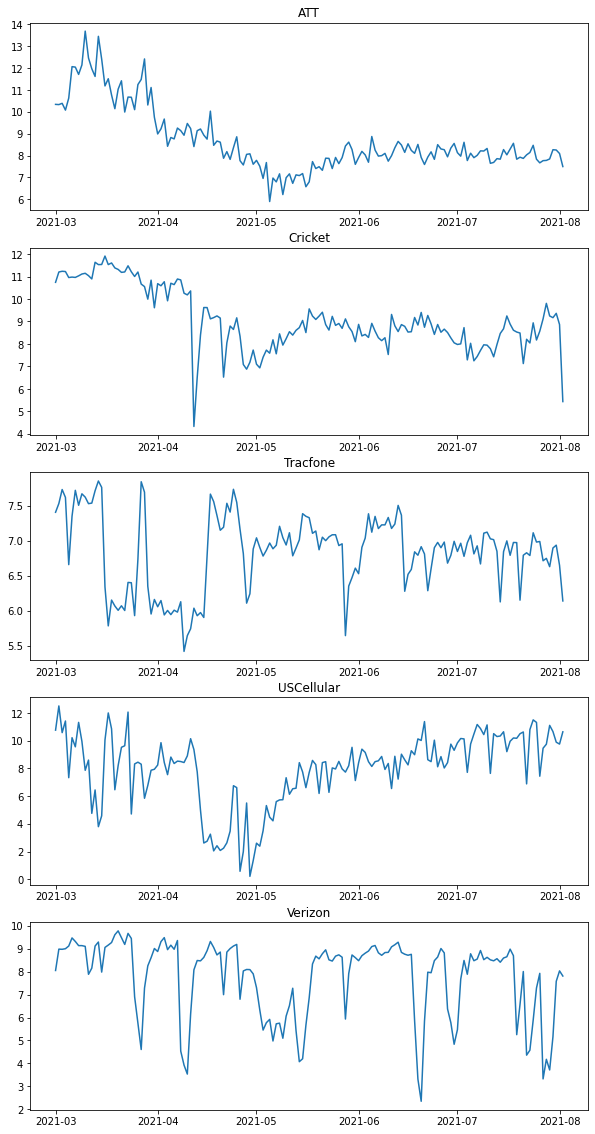

In [45]:
pivot = df_preload_device.pivot_table(values = ['sponsored_preloads', 'advertising_id'], index = 'first_date', columns = 'c_name', aggfunc = {'sponsored_preloads':sum, 'advertising_id':lambda x:len(x.unique())})
carriers = pivot.columns.get_level_values(1).unique()

fig, ax = plt.subplots(len(carriers),1, figsize = (10, len(carriers)*4))
for i in range(len(carriers)):
    c = carriers[i]
    pivot[('slots_per_device',c)] = pivot[('sponsored_preloads',c)]/pivot[('advertising_id',c)]
    ax[i].plot(pivot[('slots_per_device',c)])
    ax[i].set_title(c)

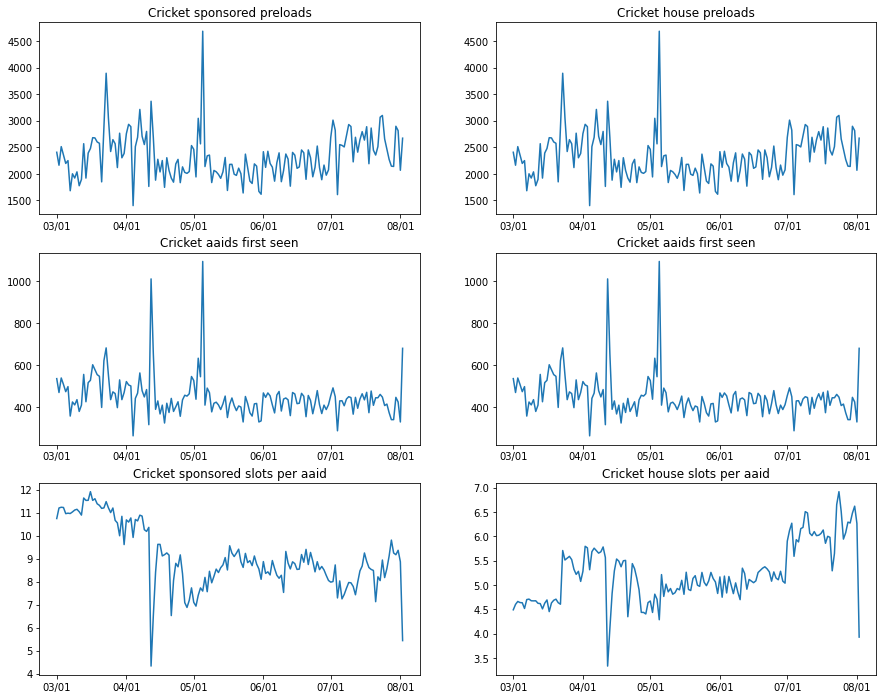

In [46]:
pivot = df_preload_device[df_preload_device.c_name == 'Cricket'].pivot_table(values = ['advertising_id','sponsored_preloads','house_preloads'], index = 'first_date'
                                                                             , aggfunc = {'house_preloads':sum,'sponsored_preloads':sum,'advertising_id':lambda x:len(x.unique())})
pivot['sponsored_slots_per_device'] = pivot['sponsored_preloads']/pivot['advertising_id']
pivot['house_slots_per_device'] = pivot['house_preloads']/pivot['advertising_id']

fig, ax = plt.subplots(3,2,figsize = (15,12))
ax[0,0].plot(pivot['house_preloads'])
ax[0,0].set_title('Cricket sponsored preloads')
ax[0,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,0].plot(pivot['advertising_id'])
ax[1,0].set_title('Cricket aaids first seen')
ax[1,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,0].plot(pivot['sponsored_slots_per_device'])
ax[2,0].set_title('Cricket sponsored slots per aaid')
ax[2,0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[0,1].plot(pivot['house_preloads'])
ax[0,1].set_title('Cricket house preloads')
ax[0,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1,1].plot(pivot['advertising_id'])
ax[1,1].set_title('Cricket aaids first seen')
ax[1,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[2,1].plot(pivot['house_slots_per_device'])
ax[2,1].set_title('Cricket house slots per aaid')
ax[2,1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))

Looks like this (slots per aaid) should be a decent proxy for configured sponsored slots..
Also, very interesting that house slots seems to have increased.


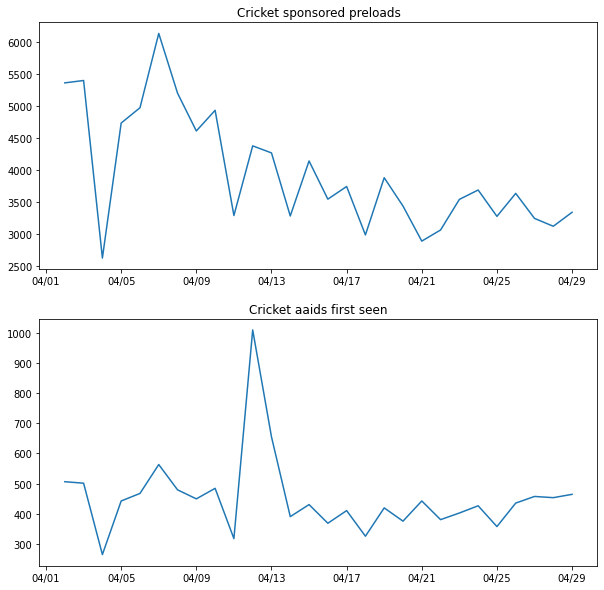

In [47]:
filters = (df_preload_device.c_name == 'Cricket') & (df_preload_device.first_date > datetime.datetime(2021,4,1)) & (df_preload_device.first_date < datetime.datetime(2021,4,30))
pivot = df_preload_device[filters].pivot_table(values = ['advertising_id','sponsored_preloads'], index = 'first_date', aggfunc = {'sponsored_preloads':sum,'advertising_id':lambda x:len(x.unique())})
pivot['slots_per_device'] = pivot['sponsored_preloads']/pivot['advertising_id']

fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(pivot['sponsored_preloads'])
ax[0].set_title('Cricket sponsored preloads')
ax[0].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))
ax[1].plot(pivot['advertising_id'])
ax[1].set_title('Cricket aaids first seen')
ax[1].xaxis.set_major_formatter(mdate.DateFormatter('%m/%d'))

### What is this spike in advertising ids on 4/12?

In [48]:
i = 'isfdr'
filters = (df_preload_device.c_name == 'Cricket') & (df_preload_device.first_date >= datetime.datetime(2021,4,11)) & (df_preload_device.first_date <= datetime.datetime(2021,4,12))
pivot = df_preload_device[filters].pivot_table(values = 'advertising_id', index = i, columns = 'first_date', aggfunc = lambda x:len(x.unique()), margins = True)

pivot['pct_change'] = 100*pivot[datetime.datetime(2021,4,12)]/pivot[datetime.datetime(2021,4,11)]-100
pivot.columns = [pd.to_datetime(x).strftime('%Y-%m-%d') for x in pivot.columns[:-2]] + pivot.columns[-2:].to_list()
pivot.sort_values('2021-04-12', ascending = False, inplace = True)
pivot.style.format({'pct_change':'{:.0f}%'}).background_gradient(cmap=cm, subset = 'pct_change')


In [49]:
i = 'c_name'
filters = (df_preload_device.first_date >= datetime.datetime(2021,4,11)) & (df_preload_device.first_date <= datetime.datetime(2021,4,12))
pivot = df_preload_device[filters].pivot_table(values = 'advertising_id', index = i, columns = 'first_date', aggfunc = lambda x:len(x.unique()), margins = True)

pivot['pct_change'] = 100*pivot[datetime.datetime(2021,4,12)]/pivot[datetime.datetime(2021,4,11)]-100
pivot.columns = [pd.to_datetime(x).strftime('%Y-%m-%d') for x in pivot.columns[:-2]] + pivot.columns[-2:].to_list()
pivot.sort_values('2021-04-12', ascending = False, inplace = True)
pivot.style.format({'pct_change':'{:.0f}%'}).background_gradient(cmap=cm, subset = 'pct_change')

Wasn't as much on other carriers..

In [50]:
i = df_preload_device.columns[12:14].to_list()
filters = (df_preload_device.c_name == 'Cricket') & (df_preload_device.first_date >= datetime.datetime(2021,4,8)) & (df_preload_device.first_date <= datetime.datetime(2021,4,12))
pivot = df_preload_device[filters].pivot_table(values = 'advertising_id', index = i, columns = 'first_date', aggfunc = lambda x:len(x.unique()), margins = True).iloc[:,:-1]
pivot['pre_412_avg'] = pivot[pivot.columns[:pivot.columns.to_list().index(datetime.datetime(2021,4,12))]].mean(axis=1)
pivot['pct_change'] = 100*pivot[datetime.datetime(2021,4,12)]/pivot['pre_412_avg']-100
pivot.columns = [pd.to_datetime(x).strftime('%Y-%m-%d') for x in pivot.columns[:-2]] + pivot.columns[-2:].to_list()
pivot.sort_values('2021-04-12', ascending = False, inplace = True)
pivot.head(20).style.format('{:,.0f}').format({'pct_change':'{:.0f}%'}).background_gradient(cmap=cm, subset = 'pct_change')


In [51]:
i = 'site_name'
filters = (df_preload_device.c_name == 'Cricket') & (df_preload_device.first_date >= datetime.datetime(2021,4,8)) & (df_preload_device.first_date <= datetime.datetime(2021,4,12))
pivot = df_preload_device[filters].pivot_table(values = 'advertising_id', index = i, columns = 'first_date', aggfunc = lambda x:len(x.unique()), margins = True).iloc[:,:-1]
pivot['pre_412_avg'] = pivot[pivot.columns[:pivot.columns.to_list().index(datetime.datetime(2021,4,12))]].mean(axis=1)
pivot['pct_change'] = 100*pivot[datetime.datetime(2021,4,12)]/pivot['pre_412_avg']-100
pivot.columns = [pd.to_datetime(x).strftime('%Y-%m-%d') for x in pivot.columns[:-2]] + pivot.columns[-2:].to_list()
pivot.sort_values('2021-04-12', ascending = False, inplace = True)
pivot.head(20).style.format('{:,.0f}').format({'pct_change':'{:.0f}%'}).background_gradient(cmap=cm, subset = 'pct_change')


In [52]:
i = ['campaign_name','site_name']
filters = (df_preload_device.first_date >= datetime.datetime(2021,4,8)) & (df_preload_device.first_date <= datetime.datetime(2021,4,12)) 
pivot = df_preload_device[filters].pivot_table(values = 'advertising_id', index = i, columns = 'first_date', aggfunc = lambda x:len(x.unique()), margins = True).iloc[:,:-1]
pivot['pre_412_avg'] = pivot[pivot.columns[:pivot.columns.to_list().index(datetime.datetime(2021,4,12))]].mean(axis=1)
pivot['pct_change'] = 100*pivot[datetime.datetime(2021,4,12)]/pivot['pre_412_avg']-100
pivot.columns = [pd.to_datetime(x).strftime('%Y-%m-%d') for x in pivot.columns[:-2]] + pivot.columns[-2:].to_list()
pivot.sort_values('2021-04-12', ascending = False, inplace = True)
pivot.head(20).style.format('{:,.0f}').format({'pct_change':'{:.0f}%'}).background_gradient(cmap=cm, subset = 'pct_change')


Looks like the increase on 4/12 came about 50% from site name "DT - Cricket - US - Ignite - Motorola - E5 Cruise - XT1921 - Silent	" on AdItUp-Android-16741-US-Cricket-Ignite	

# Why has Cricket preloads per aaid dropped?


In [53]:
i = 'c_name'
pivot = df_preload_device.pivot_table(values = ['advertising_id','sponsored_preloads'], index = i, columns = 'first_month', aggfunc = {'sponsored_preloads':sum, 'advertising_id':lambda x:len(x.unique())}, margins = True)

first_months = pivot.columns.get_level_values(1).unique()
for c in first_months:
    pivot[('slots',c)] = pivot[('sponsored_preloads',c)]/pivot[('advertising_id',c)]
pivot['pct_change'] = 100*pivot[('slots',7)]/pivot[('slots',3)]-100
pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)
pivot[['sponsored_preloads','slots','pct_change']].head(20).style.format('{:,.0f}').format({('pct_change',''):'{:.0f}%'}).background_gradient(cmap='Greens_r', subset = 'pct_change')


In [54]:
i = df_preload_device.columns[20]
filters = (df_preload_device.c_name == 'Cricket') 
pivot = df_preload_device[filters].pivot_table(values = ['advertising_id','sponsored_preloads'], index = i, columns = 'first_month', aggfunc = {'sponsored_preloads':sum, 'advertising_id':lambda x:len(x.unique())}, margins = True)

first_months = pivot.columns.get_level_values(1).unique()
for c in first_months:
    pivot[('slots',c)] = pivot[('sponsored_preloads',c)]/pivot[('advertising_id',c)]
pivot['pct_change'] = 100*pivot[('slots',7)]/pivot[('slots',3)]-100
pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)
pivot[['sponsored_preloads','slots','pct_change']].head(20).style.format('{:,.0f}').format({('pct_change',''):'{:.0f}%'}).background_gradient(cmap='Greens_r', subset = 'pct_change')


In [55]:
i = df_preload_device.columns[3]
filters = (df_preload_device.c_name == 'Cricket') 
pivot = df_preload_device[filters].pivot_table(values = ['advertising_id','sponsored_preloads'], index = i, columns = 'first_month', aggfunc = {'sponsored_preloads':sum, 'advertising_id':lambda x:len(x.unique())}, margins = True)

first_months = pivot.columns.get_level_values(1).unique()
for c in first_months:
    pivot[('slots',c)] = pivot[('sponsored_preloads',c)]/pivot[('advertising_id',c)]
pivot['pct_change'] = 100*pivot[('slots',7)]/pivot[('slots',3)]-100
pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)
pivot[['sponsored_preloads','slots','pct_change']].head(20).style.format('{:,.0f}').format({('pct_change',''):'{:.0f}%'}).background_gradient(cmap='Greens_r', subset = 'pct_change')


In [56]:
 df_preload_device.columns

Index(['advertising_id', 'c_name', 'site_id', 'site_name', 'country_code',
       'placement_id', 'sti_type', 'flows', 'recovery',
       'pia_revenue_setting_via', 'language', 'algorithm_id', 'campaign_id',
       'campaign_name', 'min_platform_os_version_id', 'app_identifier_id',
       'min_performance_score', 'isfdr', 'date', 'first_date',
       'total_campaigns_requested', 'all_preloads', 'house_preloads',
       'sponsored_preloads', 'first_month'],
      dtype='object')

In [57]:
df_preload_device['date_diff'] = pd.to_datetime(df_preload_device.date) - pd.to_datetime(df_preload_device.first_date)

i = 'date_diff'
filters = (df_preload_device.c_name == 'Cricket') 
pivot = df_preload_device[filters].pivot_table(values = ['advertising_id','sponsored_preloads'], index = i, columns = 'first_month', aggfunc = {'sponsored_preloads':sum, 'advertising_id':lambda x:len(x.unique())}, margins = True)

first_months = pivot.columns.get_level_values(1).unique()
for c in first_months:
    pivot[('slots',c)] = pivot[('sponsored_preloads',c)]/pivot[('advertising_id',c)]
pivot['pct_change'] = 100*pivot[('slots',7)]/pivot[('slots',3)]-100
pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)
pivot[['sponsored_preloads','slots','pct_change']].head(20).style.format('{:,.0f}').format({('pct_change',''):'{:.0f}%'}).background_gradient(cmap='Greens_r', subset = 'pct_change')


In [58]:
cricket_ignite_query = """
select
    t1.date
    , t1.site_name
    , t1.isfdr
    , t2.mccmnc
    , t2.os
    , t2.igniteversioncode
    , t2.igniteversionname
    , count(distinct advertising_id) as advertising_id
    , sum(t1.all_preloads) as all_preloads
    , sum(t1.house_preloads) as house_preloads
    , sum(t1.sponsored_preloads) as sponsored_preloads
from 
(
    select
        date(ctp.tracking_time) as date
        , reqid
        , advertising_id
        , case 
            when p.partner_name like '%America Movil%' then 'AMXAPK'
            else replace(replace(substring(p.partner_name,3),' ',''),'&','')
        end as c_name
        , ctp.site_id
        , s.site_name
        , case when ctp.placement_id = 99 then 1 else 0 end as isfdr
        , count(distinct referrer) as all_preloads
        , count(distinct case when settled_price_per_download = 0 then referrer else NULL end) as house_preloads
        , count(distinct case when settled_price_per_download > 0 then referrer else NULL end) as sponsored_preloads
    from rawdata.campaign_tracking_active_preload ctp
    join rawdata.site s
        on ctp.site_id = s.site_id
    join rawdata.partner_information p
        on s.partner_id = p.partner_id 
    where
        date(ctp.tracking_time) >= date('{start_dt}')
        and date(ctp.tracking_time) <= date('{end_dt}')
        and right(reqid,1) in ('0','1','2','3')
        and p.partner_name = 'DT Cricket'
    group by 1,2,3,4,5,6,7
) t1 
left join
(
    SELECT 
        DISTINCT p.uid||'_'||t.transactionid AS reqid
        , max(p.mccmnc) mccmnc
        , max(os) os
        , max(igniteversioncode) igniteversioncode
        , max(igniteversionname) igniteversionname
    FROM rawdata.dt_process p
    JOIN rawdata.dt_transactions t 
        USING (processid , rs_carrier_id)
    JOIN rawdata.dt_transactions_events te 
        USING (transactionid, rs_carrier_id)
    join rawdata.dt_events e 
        USING (eventId, rs_carrier_id)
    join rawdata.dt_device_os os 
        USING (deviceosid, rs_carrier_id)
    WHERE 
        e.code = 490
        and p.rs_carrier_id in (11,13)
        and right(t.transactionid,1) in ('0','1','2','3')
        AND DATE(te.eventdate) >= date('{start_dt}')
        AND DATE(te.eventdate) <= date('{end_dt}')
    GROUP BY 1
) t2 
    on t1.reqid = t2.reqid
group by 1,2,3,4,5,6,7
"""
cur_atlas.execute(cricket_ignite_query.format(start_dt = start_dt, end_dt = end_dt))
df_cricket_ignite = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [59]:
df_cricket_ignite['month'] = pd.to_datetime(df_cricket_ignite.date).dt.month
df_cricket_ignite['os_major'] = df_cricket_ignite.os.str.split('.').str[0]
df_cricket_ignite['ignite_major'] = df_cricket_ignite.igniteversionname.str.split('.').str[0]
df_cricket_ignite

date                                          site_name  isfdr  \
0       2021-03-01  DT - Cricket - US - Ignite - Samsung - A01 - S...      0   
1       2021-03-01  DT - Cricket - US - Ignite - LG - Escape Plus ...      0   
2       2021-03-02  DT - Cricket - US - Ignite - Samsung - A01 - S...      0   
3       2021-03-02  DT - Cricket - US - Ignite - Emblem - Cricket ...      0   
4       2021-03-02  DT - Cricket - US - Ignite - LG - Stylo 5 - LM...      0   
...            ...                                                ...    ...   
136596  2021-07-31  DT - Cricket - US - Ignite - Alcatel - Pixi Th...      1   
136597  2021-07-27  DT - Cricket - US - Ignite - Samsung - A10e - ...      0   
136598  2021-08-01  DT - Cricket - US - Ignite - Alcatel - ONYX - ...      0   
136599  2021-08-02  DT - Cricket - US - Ignite - Emblem - Cricket ...      0   
136600  2021-07-31  DT - Cricket - US - Ignite - LG - Fortune 2 - ...      0   

        mccmnc     os igniteversioncode igniteversionname  advertising_id  \
0       310150     10          61037000  6.1.037.000-4922             166   
1       310150     10          70107000  7.0.107.000-5316              77   
2       310150     10          70107000  7.0.107.000-5316            2588   
3       310150      9          53007000  5.3.007.000-4521              48   
4       000000     10          63086000  6.3.086.000-5105               7   
...        ...    ...               ...               ...             ...   
136596    None   None              None              None               1   
136597  000000     10          71214000  7.1.214.000-5411               1   
136598  310150  8.1.0          71214000  7.1.214.000-5411               1   
136599  000000     10          61037000  6.1.037.000-4922               1   
136600  702695  7.1.2          31024000  3.1.024.000-1374               1   

        all_preloads  house_preloads  sponsored_preloads  month os_major  \
0                637             261                 376      3       10   
1                553             161                 392      3       10   
2              10927            3875                7052      3       10   
3                149              93                  56      3        9   
4                 24               9                  15      3       10   
...              ...             ...                 ...    ...      ...   
136596             2               1                   1      7     None   
136597             1               0                   1      7       10   
136598             2               1                   1      8        8   
136599             1               1                   0      8       10   
136600             1               1                   0      7        7   

       ignite_major  
0                 6  
1                 7  
2                 7  
3                 5  
4                 6  
...             ...  
136596         None  
136597            7  
136598            7  
136599            6  
136600            3  

[136601 rows x 14 columns]

In [60]:
i = ['ignite_major']
filters = df_cricket_ignite.date >= datetime.date(2021,3,1)
pivot = df_cricket_ignite[filters].fillna(-1).pivot_table(values = ['advertising_id','sponsored_preloads'], index = i, columns = 'month', aggfunc = {'sponsored_preloads':sum, 'advertising_id':lambda x:len(x.unique())}, margins = True)
months = pivot.columns.get_level_values(1).unique()
for c in months:
    pivot[('slots',c)] = pivot[('sponsored_preloads',c)]/pivot[('advertising_id',c)]
pivot['pct_change'] = 100*pivot[('slots',7)]/pivot[('slots',3)]-100
pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)
pivot[['sponsored_preloads','slots','pct_change']].head(20).style.format('{:,.0f}').format({('pct_change',''):'{:.0f}%'}).background_gradient(cmap='Greens_r', subset = 'pct_change')


In [61]:
filters = (df_cricket_ignite.date >= pd.to_datetime('2021-05-01')) & (df_cricket_ignite.date <= pd.to_datetime('2021-05-31'))
df_cricket_ignite[filters].groupby('igniteversioncode')['all_preloads'].sum().sort_values(ascending = False).head(10)

igniteversioncode
71214000    4243047
63086000     155389
61037000      87024
70107000      68425
64145000      17072
53004000      11996
53007000       6793
54042000       4432
56053000       4060
40132000       3479
Name: all_preloads, dtype: int64

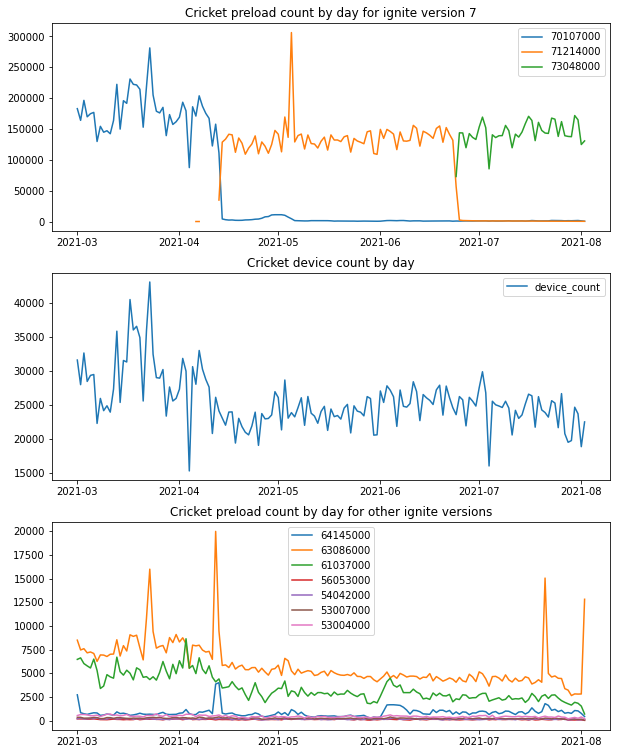

In [73]:
pivot = df_cricket_ignite.pivot_table(values = 'all_preloads', index = 'date', columns = 'igniteversioncode', aggfunc = np.sum)
fig, ax = plt.subplots(3,1,figsize = (10,13))
ax[0].plot(pivot[['70107000','71214000','73048000']])
ax[0].set_title('Cricket preload count by day for ignite version 7')
ax[0].legend(['70107000','71214000','73048000'])
ax[1].plot(cricket_bydate.set_index('date')['device_count'])
ax[1].legend(['device_count'])
ax[1].set_title('Cricket device count by day')
ax[2].plot(pivot[['64145000','63086000','61037000','56053000','54042000','53007000','53004000']])
ax[2].set_title('Cricket preload count by day for other ignite versions')
ax[2].legend(['64145000','63086000','61037000','56053000','54042000','53007000','53004000'])


*Correlate with GetAds calls by day - related to Ignite release? 


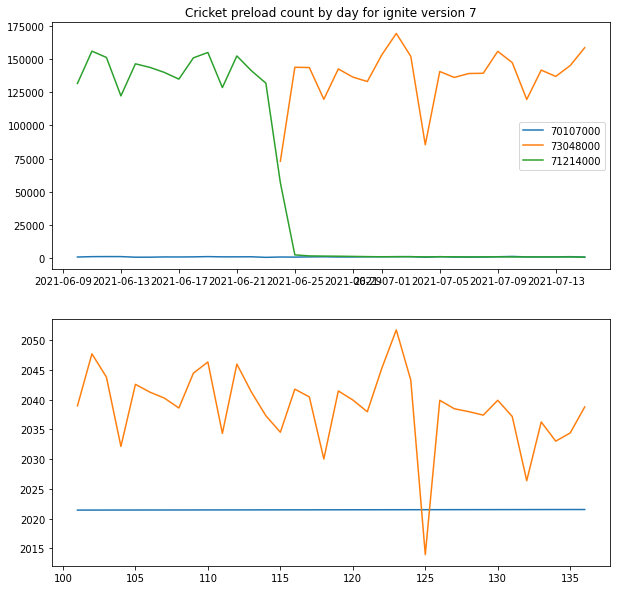

In [63]:
pivot = df_cricket_ignite.pivot_table(values = 'all_preloads', index = 'date', columns = 'igniteversioncode', aggfunc = np.sum)
device_ct = cricket_bydate.loc[:,['date','device_count']]

start_range = '2021-06-10'
end_range = '2021-07-15'
filters = (pivot.index >= pd.to_datetime(start_range)) & (pivot.index <= pd.to_datetime(end_range))
filters2 = (device_ct.date >= pd.to_datetime(start_range)) & (device_ct.date <= pd.to_datetime(end_range))

fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(pivot.loc[filters, ['70107000','73048000','71214000']])
ax[0].set_title('Cricket preload count by day for ignite version 7')
ax[0].legend(['70107000','73048000','71214000'])
ax[1].plot(device_ct.loc[filters2])



In [64]:
i = ['os']
filters = df_cricket_ignite.date >= datetime.date(2021,3,1)
pivot = df_cricket_ignite[filters].fillna(-1).pivot_table(values = ['advertising_id','sponsored_preloads'], index = i, columns = 'month', aggfunc = {'sponsored_preloads':sum, 'advertising_id':lambda x:len(x.unique())}, margins = True)
months = pivot.columns.get_level_values(1).unique()
for c in months:
    pivot[('slots',c)] = pivot[('sponsored_preloads',c)]/pivot[('advertising_id',c)]
pivot['pct_change'] = 100*pivot[('slots',7)]/pivot[('slots',3)]-100
pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)
pivot[['sponsored_preloads','slots','pct_change']].head(20).style.format('{:,.0f}').format({('pct_change',''):'{:.0f}%'}).background_gradient(cmap='Greens_r', subset = 'pct_change')


In [65]:
i = ['mccmnc']
filters = df_cricket_ignite.date >= datetime.date(2021,3,1)
pivot = df_cricket_ignite[filters].fillna(-1).pivot_table(values = ['advertising_id','sponsored_preloads'], index = i, columns = 'month', aggfunc = {'sponsored_preloads':sum, 'advertising_id':lambda x:len(x.unique())}, margins = True)
months = pivot.columns.get_level_values(1).unique()
for c in months:
    pivot[('slots',c)] = pivot[('sponsored_preloads',c)]/pivot[('advertising_id',c)]
pivot['pct_change'] = 100*pivot[('slots',7)]/pivot[('slots',3)]-100
pivot.sort_values(('sponsored_preloads',3), ascending = False, inplace = True)
pivot[['sponsored_preloads','slots','pct_change']].head(20).style.format('{:,.0f}').format({('pct_change',''):'{:.0f}%'}).background_gradient(cmap='Greens_r', subset = 'pct_change')
